# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement

Climate Change can have wide and systemic impacts, varying from atmospheric, environmental, weather, and water quality. I'd like to identify how Climate Change has impacted the area I live in (Lander Wyoming).
Particularly I'd like to investigate temperature fluctuations, and radiation levels.


### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Open Meteo - Hourly Radiation Weather Data**

Type: Tabular records for hourly weather reporting in Lander Wyoming.

Method: Gather data by accessing the Open Meteo Historical Weather Data API.

The first dataset will come from the [Open Meteo API](https://open-meteo.com/en/docs/historical-forecast-api). Source information for this dataset can be found [here](https://open-meteo.com/en/docs/historical-forecast-api#data_sources).
_NOTE:_ This archival API only has access to 2016 and beyond.

Hourly Weather dataset variables:
* **latitude**: float - latitude of the location
* **longitude**: float - longitude of the location
* **start_date**: datetime - start of hour (America/Denver)
* **end_date**: datetime - end of hour (America/Denver)
* **shortwave_radiation**: float - average temperature aggregated by 2m intervals (fahrenheit)
* **direct_radiation**: float - sum of precipitation in (inch)
* **diffuse_radiation**: float - amount of diffused radiation
* **direct_normal_irradiance**: float - amount of direct normal irradiance
* **global_tilted_irradiance**: float - amount of global tilted irradiance radiation
* **terrestrial_radiation** - float - amount of terrestrial radiation

In [1]:
from weather_api_importer import (
    get_hourly_weather_records_by_date,
    insert_hourly_weather_records,
)
from models import (
    NOAAStationMonthlySummary,
    Base,
    Location,
    OMSolarMonthlyWeatherRecord,
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import insert, select, create_engine
import numpy as np

# Lander Wyoming Lat/Long values
LATITUDE: float = 42.8330
LONGITUDE: float = 108.7307
START_DATE = "2016-02-01"
END_DATE = "2025-08-01"
ENGINE = create_engine("sqlite:///weather.db")
# Will be the default in future versions of Pandas
pd.options.mode.copy_on_write = True

In [2]:
# Build the models within the SQLite Database
Base.metadata.create_all(ENGINE)
with ENGINE.begin() as conn:  # transactional context
    default_location = conn.execute(
        select(Location.id).where(
            Location.latitude == LATITUDE,
            Location.longitude == LONGITUDE,
        )
    ).scalar_one_or_none()

    if default_location is None:
        conn.execute(
            insert(Location).values(
                latitude=LATITUDE,
                longitude=LONGITUDE,
                friendly_name="Lander, Wyoming",
            )
        )

In [3]:
# Identify if Open Meteo data should be imported
# RUN the following IF importing fresh data
# OMSolarHourlyWeatherRecord.__table__.drop(ENGINE, checkfirst=True)
# OMSolarHourlyWeatherRecord.__table__.create(ENGINE, checkfirst=True)
df_om_solar_hourly = pd.read_sql_table("om_solar_hourly_weather", ENGINE)
if df_om_solar_hourly.empty:
    hourly_records = get_hourly_weather_records_by_date(
        start_date=START_DATE, end_date=END_DATE
    )
    insert_hourly_weather_records(hourly_records)

df_om_solar_hourly = pd.read_sql_table("om_solar_hourly_weather", ENGINE)

In [4]:
df_om_solar_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83280 entries, 0 to 83279
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        83280 non-null  int64         
 1   location_id               83280 non-null  int64         
 2   date                      83280 non-null  datetime64[ns]
 3   shortwave_radiation       83280 non-null  float64       
 4   direct_radiation          83280 non-null  float64       
 5   diffuse_radiation         83280 non-null  float64       
 6   direct_normal_irradiance  83280 non-null  float64       
 7   global_tilted_irradiance  83280 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 5.1 MB


#### NOAA Monthly Summary

Type: CSV File


Method: From this [link](https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-month), filter the location to Lander Wyoming and download the full data set for 'LANDER AIRPORT, WY US (USW00024021.csv)'

This DataSet was gathered from the National Centers for Environmental Information (NOAA), and is representative of the Lander Wyoming Weather data since 1948.
More specifically this source is from the [Global Summary of the Month](https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-month) aggregate dataset.
This data will be parsed and paired down to a usable dataset, and later stored to then compare with current trends from Data Set 1.

The dataset has 110 columns to choose from, all of which use a shorthand. [This PDF](https://www.ncei.noaa.gov/pub/data/cdo/documentation/GSOM_documentation.pdf) can be used as a reference.



In [5]:
df_noaa = pd.read_csv("./USWGlobalSummaryOfTheMonth.csv")

In [6]:
df_noaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Columns: 110 entries, STATION to WSFM_ATTRIBUTES
dtypes: float64(54), int64(4), object(52)
memory usage: 799.3+ KB


## Dataset 2 fields of interest
* DATE - datetime
* LATITUDE - float
* LONGITUDE - float
* NAME - string
* ADPT - Monthly Average Dew Point Temperature
* AWND - Monthly Average Wind Speed
* CDSD - Cooling Degree Days (season-to-date)
* DP01 - Number of days with >= 0.01 inch/0.254 millimeter in the month
* DP1X - Number of days with >= 1.00 inch/25.4 millimeters in the month
* DSND - Number of days with snow depth >= 1 inch/25 millimeters
* DSNW - Number of days with snowfall >= 1 inch/25 millimeters
* DT00 Number of days with maximum temperature <= 0 degrees Fahrenheit/-17.8 degrees Celsius
* DT32 - Number of days with minimum temperature <= 32 degrees Fahrenheit/0 degrees Celsius
* DX32 - Number of days with maximum temperature <= 32 degrees Fahrenheit/0 degrees Celsius
* DX70 - Number of days with maximum temperature >= 70 degrees Fahrenheit/21.1 degrees Celsius
* DX90 - Number of days with maximum temperature >= 90 degrees Fahrenheit/32.2 degrees Celsius
* EMNT - Extreme minimum temperature for month. Lowest daily minimum temperature for the
month
* EMXP - Highest daily total of precipitation in the month. Given in inches or millimeters depending
on user specification
* EMXT - Extreme maximum temperature for month. Highest daily maximum temperature for the
month. Given in Celsius or Fahrenheit depending on user specification
* PRCP - Total Monthly Precipitation
* PSUN - Monthly Average of the daily percents of possible sunshine
* SNOW - Total Monthly Snowfall
* TAVG - Average Monthly Temperature
* TMAX - Monthly Maximum Temperature. Average of daily maximum temperature
* TMIN - Monthly Minimum Temperature. Average of daily minimum temperature
* TSUN - Daily total sunshine in minutes

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:
Several columns are set as the incorrect datatype, and should be modified to meet their current representation of either a count of Days (int64), a float value, or string.
Issue and justification:
Not having the correct data types for these fields will lead to incorrect analysis down the line.

In [7]:
# The DF Hourly data is in good shape for null values and data types
df_om_solar_hourly.isnull().sum()

id                          0
location_id                 0
date                        0
shortwave_radiation         0
direct_radiation            0
diffuse_radiation           0
direct_normal_irradiance    0
global_tilted_irradiance    0
dtype: int64

In [8]:
df_om_solar_hourly.isna().sum()

id                          0
location_id                 0
date                        0
shortwave_radiation         0
direct_radiation            0
diffuse_radiation           0
direct_normal_irradiance    0
global_tilted_irradiance    0
dtype: int64

In [9]:
df_om_solar_hourly.dtypes

id                                   int64
location_id                          int64
date                        datetime64[ns]
shortwave_radiation                float64
direct_radiation                   float64
diffuse_radiation                  float64
direct_normal_irradiance           float64
global_tilted_irradiance           float64
dtype: object

In [10]:
# The date format is YYYY-MM and is an object type and should be setup as a datetime for later filtering of columns
print(df_noaa.dtypes)
df_noaa["DATE"].head()

STATION             object
DATE                object
LATITUDE           float64
LONGITUDE          float64
ELEVATION          float64
                    ...   
WSF5_ATTRIBUTES     object
WSFG               float64
WSFG_ATTRIBUTES     object
WSFM               float64
WSFM_ATTRIBUTES     object
Length: 110, dtype: object


0    1948-01
1    1948-02
2    1948-03
3    1948-04
4    1948-05
Name: DATE, dtype: object

In [11]:
# Dates look good for Open Meteo Dataset
df_om_solar_hourly["date"].head()

0   2016-02-01 06:00:00
1   2016-02-01 07:00:00
2   2016-02-01 08:00:00
3   2016-02-01 09:00:00
4   2016-02-01 10:00:00
Name: date, dtype: datetime64[ns]

### Quality Issue 2:
The NOAA Dataset has a large number of null values for the chosen location. Sort through these and drop ones that are primarily null.

In [12]:
df_noaa.isnull().sum().sort_values(ascending=False)
# I suspect the missing values may be related to dates

DYHF_ATTRIBUTES    930
DYFG_ATTRIBUTES    930
DYTS_ATTRIBUTES    930
WDF1               857
WSF1_ATTRIBUTES    857
                  ... 
PRCP                 0
DYXP_ATTRIBUTES      0
DYXP                 0
EMXP                 0
EMXP_ATTRIBUTES      0
Length: 110, dtype: int64

### Tidiness Issue 1:
Given that we know the location is Lander Wyoming we can drop that data and replace it with location id = 1 prior to storing

In [13]:
# FILL IN - Inspecting the dataframe visually
df_noaa[["NAME", "LATITUDE", "LONGITUDE", "STATION", "ELEVATION"]].value_counts()

NAME                   LATITUDE  LONGITUDE   STATION      ELEVATION
LANDER AIRPORT, WY US  42.81536  -108.72604  USW00024021  1698.5       930
Name: count, dtype: int64

### Tidiness Issue 2:
The incoming data is setup as hourly data, this is great for granularity, but to compare to the monthly summary we will need to build up a monthly set

In [14]:
df_om_solar_hourly.describe()

,id,location_id,date,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance
count,83280.000000,83280.0,83280,83280.000000,83280.000000,83280.000000,83280.000000,83280.000000
mean,41640.500000,1.0,2020-11-01 05:30:00,187.987008,113.440058,74.546950,206.532118,187.987008
min,1.000000,1.0,2016-02-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20820.750000,1.0,2018-06-17 17:45:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41640.500000,1.0,2020-11-01 05:30:00,11.000000,0.000000,10.000000,0.000000,11.000000
75%,62460.250000,1.0,2023-03-18 17:15:00,364.000000,200.000000,137.000000,441.862122,364.000000
max,83280.000000,1.0,2025-08-02 05:00:00,958.000000,792.000000,477.000000,926.295837,958.000000
std,24041.009546,0.0,NaN,255.626709,174.659486,96.461558,275.243797,255.626709


## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [15]:
df_om_solar_hourly_copy = df_om_solar_hourly.copy()
df_noaa_copy = df_noaa.copy()

### **Quality Issue 1:**
Setup as a proper types for each column (based on the aforementioned PDF), then abstract out a year and month column for later grouping

In [16]:
df_noaa_copy.loc[:, "year"] = pd.Series(
    [dt[1].split("-")[0] for dt in df_noaa_copy["DATE"].items()]
)
df_noaa_copy.loc[:, "month"] = pd.Series(
    [dt[1].split("-")[1] for dt in df_noaa_copy["DATE"].items()]
)
df_noaa_copy.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ADPT,ADPT_ATTRIBUTES,ASLP,ASLP_ATTRIBUTES,...,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WSFG,WSFG_ATTRIBUTES,WSFM,WSFM_ATTRIBUTES,year,month
0,USW00024021,1948-01,42.81536,-108.72604,1698.5,"LANDER AIRPORT, WY US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948,01
1,USW00024021,1948-02,42.81536,-108.72604,1698.5,"LANDER AIRPORT, WY US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948,02
2,USW00024021,1948-03,42.81536,-108.72604,1698.5,"LANDER AIRPORT, WY US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948,03
3,USW00024021,1948-04,42.81536,-108.72604,1698.5,"LANDER AIRPORT, WY US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948,04
4,USW00024021,1948-05,42.81536,-108.72604,1698.5,"LANDER AIRPORT, WY US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948,05


In [17]:
# Ensure data integrity prior to conversion, ignoring attributes and non-essential columns
int_cols = [
    "DP01",
    "DP10",
    "DP1X",
    "DSND",
    "DSNW",
    "DT00",
    "DT32",
    "DX32",
    "DX70",
    "DX90",
    "DYFG",
    "DYHF",
    "DYNT",
    "DYSD",
    "DYSN",
    "DYTS",
    "DYXP",
    "DYXT",
    "WDF2",
    "WDF5",
]
float_cols = [
    "CDSD",
    "CLDD",
    "EMNT",
    "EMSD",
    "EMSN",
    "EMXP",
    "EMXT",
    "HDSD",
    "HTDD",
    "PRCP",
    "SNOW",
    "TAVG",
    "TMAX",
    "TMIN",
    "WSF2",
    "WSF5",
]

for col in int_cols:
    if col in df_noaa_copy.columns:
        df_noaa_copy[col] = pd.to_numeric(df_noaa_copy[col], errors="coerce").astype(
            "Int64"
        )

for col in float_cols:
    if col in df_noaa_copy.columns:
        df_noaa_copy[col] = pd.to_numeric(df_noaa_copy[col], errors="coerce").astype(
            float
        )

# Ensure date is datetime64[ns] representing the first day of the month
df_noaa_copy["date"] = pd.to_datetime(
    df_noaa_copy["DATE"], format="%Y-%m", errors="raise"
)

# Inspect dtypes after coercion
df_noaa_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Columns: 113 entries, STATION to date
dtypes: Int64(20), datetime64[ns](1), float64(38), object(54)
memory usage: 839.3+ KB


### **Quality Issue 2**
Identifying null columns and dropping ones that exceed a reasonable threshold. If a pattern develops by year we could shorten the time span for comparision.

In [18]:
# Ensure we filter out the _ATTRIBUTE columns to shorten the width of this df
df_noaa_copy = df_noaa_copy[
    [col for col in df_noaa_copy.columns if not col.endswith("_ATTRIBUTES")]
]

# Count total rows per year (denominator)
rows_per_year = df_noaa_copy.groupby("year").size()

# Sum of nulls per year by selected columns
nulls_by_year = df_noaa_copy.groupby("year")[df_noaa_copy.columns].apply(
    lambda g: g.isnull().sum()
)

# Convert to proportions
null_proportion_by_year = (nulls_by_year.div(rows_per_year, axis=0) * 100).round(1)

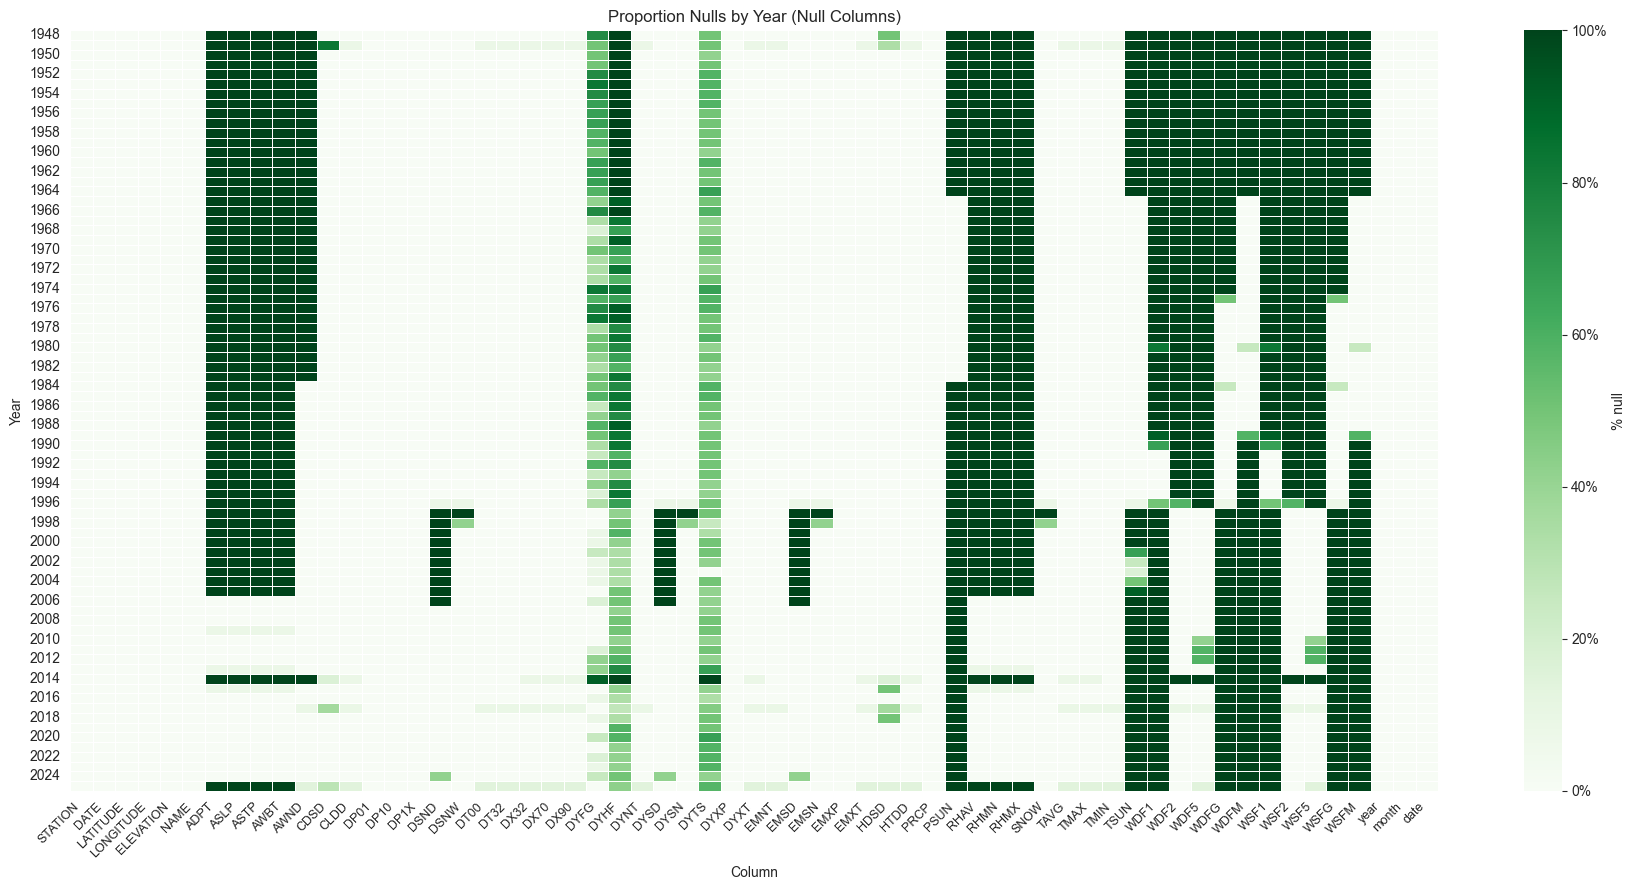

In [19]:
plt.figure(figsize=(18, 9))
ax = sns.heatmap(
    null_proportion_by_year,
    annot=False,
    cmap="Greens",
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "% null", "format": "%.0f%%"},
)
plt.title("Proportion Nulls by Year (Null Columns)")
plt.ylabel("Year")
plt.xlabel("Column")
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [20]:
# Using the heatmap above I can visually see where some fields are null and at which year they are concentrated.
# To clean up this chart we filter out columns that won't be useful for analysis (null columns), and include fields of interest
try:
    df_noaa_copy.drop(
        [
            "ADPT",
            "ASLP",
            "ASTP",
            "AWBT",
            "AWND",
            "PSUN",
            "RHAV",
            "RHMN",
            "RHMX",
            "TSUN",
            "WDF1",
            "WDFG",
            "WDFM",
            "WSF1",
            "WSFG",
            "WSFM",
        ],
        axis=1,
        inplace=True,
    )
except KeyError:
    # Already dropped these columns
    pass
rows_per_year = df_noaa_copy.groupby("year").size()
nulls_by_year = df_noaa_copy.groupby("year")[df_noaa_copy.columns].apply(
    lambda g: g.isnull().sum()
)
null_proportion_by_year = (nulls_by_year.div(rows_per_year, axis=0) * 100).round(1)

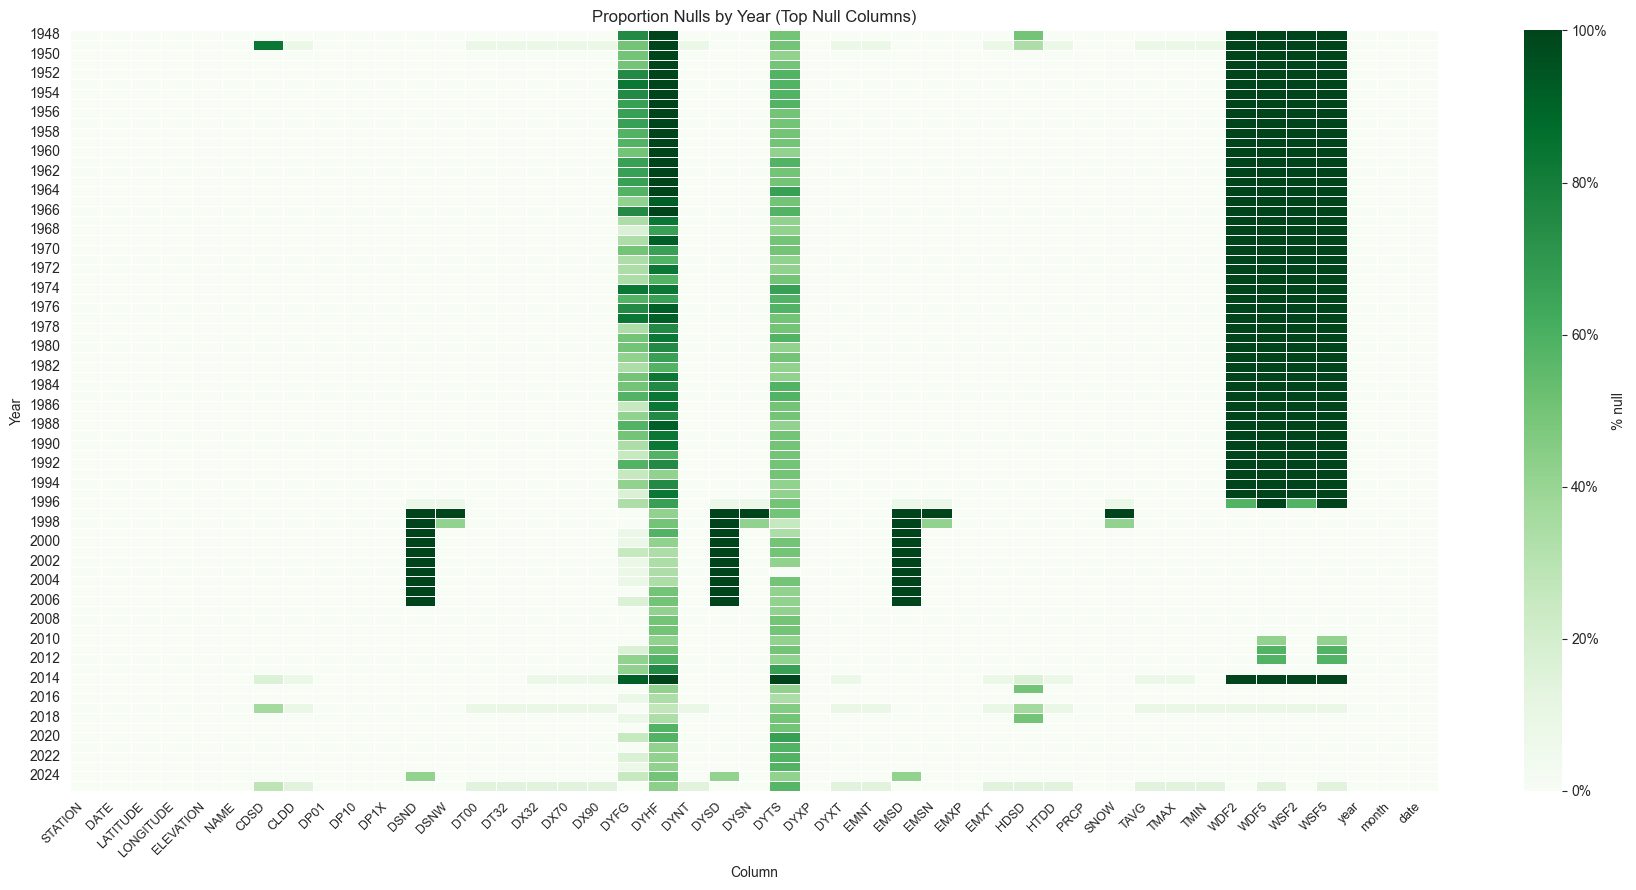

In [21]:
# Rebuild the same heatmap to determine the concentration of columns that have values
plt.figure(figsize=(18, 9))
ax = sns.heatmap(
    null_proportion_by_year,
    annot=False,
    cmap="Greens",
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "% null", "format": "%.0f%%"},
)
plt.title("Proportion Nulls by Year (Top Null Columns)")
plt.ylabel("Year")
plt.xlabel("Column")
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Now the Heatmap is looking a lot cleaner. We will have to keep in mind there are some gaps with the WDF fields, but since it is bound by date (>1996) we can work around that.

### **Tidiness Issue 1**
Prior to storing we will want to bring the location data into normal form via the Location table found in models.py

In [22]:
df_noaa_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 45 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   STATION    930 non-null    object        
 1   DATE       930 non-null    object        
 2   LATITUDE   930 non-null    float64       
 3   LONGITUDE  930 non-null    float64       
 4   ELEVATION  930 non-null    float64       
 5   NAME       930 non-null    object        
 6   CDSD       912 non-null    float64       
 7   CLDD       926 non-null    float64       
 8   DP01       930 non-null    Int64         
 9   DP10       930 non-null    Int64         
 10  DP1X       930 non-null    Int64         
 11  DSND       804 non-null    Int64         
 12  DSNW       912 non-null    Int64         
 13  DT00       927 non-null    Int64         
 14  DT32       927 non-null    Int64         
 15  DX32       926 non-null    Int64         
 16  DX70       926 non-null    Int64         
 1

In [23]:
# We can remove the station
current_columns = df_noaa_copy.columns
if "STATION" in current_columns:
    df_noaa_copy.drop("STATION", axis=1, inplace=True)
if "LONGITUDE" in current_columns:
    df_noaa_copy.drop("LONGITUDE", axis=1, inplace=True)
if "LATITUDE" in current_columns:
    df_noaa_copy.drop("LATITUDE", axis=1, inplace=True)
if "NAME" in current_columns:
    df_noaa_copy.drop("NAME", axis=1, inplace=True)
if "ELEVATION" in current_columns:
    df_noaa_copy.drop("ELEVATION", axis=1, inplace=True)
if "location_id" not in current_columns:
    df_noaa_copy.loc[:, "location_id"] = 1
df_noaa_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE         930 non-null    object        
 1   CDSD         912 non-null    float64       
 2   CLDD         926 non-null    float64       
 3   DP01         930 non-null    Int64         
 4   DP10         930 non-null    Int64         
 5   DP1X         930 non-null    Int64         
 6   DSND         804 non-null    Int64         
 7   DSNW         912 non-null    Int64         
 8   DT00         927 non-null    Int64         
 9   DT32         927 non-null    Int64         
 10  DX32         926 non-null    Int64         
 11  DX70         926 non-null    Int64         
 12  DX90         926 non-null    Int64         
 13  DYFG         585 non-null    Int64         
 14  DYHF         271 non-null    Int64         
 15  DYNT         927 non-null    Int64         
 16  DYSD    

Justification: By simplifying down to a normal form location table we can expand this to join to other data sets by location and date in the future.

### **Tidiness Issue 2**
In order to compare the hourly data more efectively we will want to roll it up into a daily record table.

In [24]:
df_om_solar_hourly_copy["day"] = df_om_solar_hourly_copy["date"].dt.normalize()
df_om_solar_hourly_copy["month"] = df_om_solar_hourly_copy["date"].dt.month
df_om_solar_hourly_copy["year"] = df_om_solar_hourly_copy["date"].dt.year
df_om_solar_hourly_copy.head()
# Add in proper date formatting

,id,location_id,date,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,day,month,year
0,1,1,2016-02-01 06:00:00,528.0,434.0,94.0,885.149719,528.000000,2016-02-01,2,2016
1,2,1,2016-02-01 07:00:00,466.0,377.0,89.0,852.225464,466.000031,2016-02-01,2,2016
2,3,1,2016-02-01 08:00:00,350.0,272.0,78.0,775.896606,350.000000,2016-02-01,2,2016
3,4,1,2016-02-01 09:00:00,195.0,136.0,59.0,614.981995,195.000015,2016-02-01,2,2016
4,5,1,2016-02-01 10:00:00,43.0,22.0,21.0,200.501968,43.000000,2016-02-01,2,2016


In [25]:
df_om_solar_agg_monthly = (
    df_om_solar_hourly_copy.groupby(["month", "year"])
    .agg(
        avg_shortwave_radiation=("shortwave_radiation", "mean"),
        max_shortwave_radiation=("shortwave_radiation", "max"),
        min_shortwave_radiation=("shortwave_radiation", "min"),
        avg_direct_radiation=("direct_radiation", "mean"),
        max_direct_radiation=("direct_radiation", "max"),
        min_direct_radiation=("direct_radiation", "min"),
        avg_direct_normal_irradiance=("direct_normal_irradiance", "mean"),
        max_direct_normal_irradiance=("direct_normal_irradiance", "max"),
        min_direct_normal_irradiance=("direct_normal_irradiance", "min"),
        avg_global_tilted_irradiance=("global_tilted_irradiance", "mean"),
        max_global_tilted_irradiance=("global_tilted_irradiance", "max"),
        min_global_tilted_irradiance=("global_tilted_irradiance", "min"),
    )
    .reset_index()
)
df_om_solar_agg_monthly

,month,year,avg_shortwave_radiation,max_shortwave_radiation,min_shortwave_radiation,avg_direct_radiation,max_direct_radiation,min_direct_radiation,avg_direct_normal_irradiance,max_direct_normal_irradiance,min_direct_normal_irradiance,avg_global_tilted_irradiance,max_global_tilted_irradiance,min_global_tilted_irradiance
0,1,2017,106.275538,532.0,0.0,76.491935,430.0,0.0,226.127309,878.051331,0.0,106.275538,532.000000,0.0
1,1,2018,103.920699,518.0,0.0,72.037634,416.0,0.0,212.351794,881.876587,0.0,103.920699,517.999939,0.0
2,1,2019,105.744624,532.0,0.0,75.193548,431.0,0.0,222.891740,883.115051,0.0,105.744625,532.000000,0.0
3,1,2020,104.388441,513.0,0.0,73.419355,419.0,0.0,217.949628,871.238708,0.0,104.388440,512.999939,0.0
4,1,2021,107.873656,521.0,0.0,79.548387,432.0,0.0,236.134299,883.509460,0.0,107.873655,521.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,12,2020,91.663978,431.0,0.0,64.247312,346.0,0.0,205.938450,855.729492,0.0,91.663978,430.999969,0.0
111,12,2021,88.944892,421.0,0.0,60.627688,334.0,0.0,193.590880,832.230835,0.0,88.944892,420.999939,0.0
112,12,2022,89.751344,445.0,0.0,59.200269,329.0,0.0,188.253994,817.274902,0.0,89.751344,445.000000,0.0
113,12,2023,84.737903,422.0,0.0,54.111559,320.0,0.0,171.621420,801.503723,0.0,84.737904,422.000000,0.0


In [26]:
# Add location ID and month column to monthly DF
df_om_solar_agg_monthly["location_id"] = (
    1  # Current default location is 1 for Lander, Wyoming
)
df_om_solar_agg_monthly["date"] = (
    df_om_solar_agg_monthly["year"].astype(str)
    + "-"
    + df_om_solar_agg_monthly["month"].astype(str)
)
# Will default to the first day of the month
df_om_solar_agg_monthly["date"] = pd.to_datetime(df_om_solar_agg_monthly["date"])
df_om_solar_agg_monthly["date"].head()

0   2017-01-01
1   2018-01-01
2   2019-01-01
3   2020-01-01
4   2021-01-01
Name: date, dtype: datetime64[ns]

In [27]:
df_om_solar_agg_monthly.columns

Index(['month', 'year', 'avg_shortwave_radiation', 'max_shortwave_radiation',
       'min_shortwave_radiation', 'avg_direct_radiation',
       'max_direct_radiation', 'min_direct_radiation',
       'avg_direct_normal_irradiance', 'max_direct_normal_irradiance',
       'min_direct_normal_irradiance', 'avg_global_tilted_irradiance',
       'max_global_tilted_irradiance', 'min_global_tilted_irradiance',
       'location_id', 'date'],
      dtype='object')

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [28]:
# Ensure column ordering matches models.py file
df_om_solar_agg_monthly_final = df_om_solar_agg_monthly[
    [
        "location_id",
        "date",
        "avg_shortwave_radiation",
        "max_shortwave_radiation",
        "min_shortwave_radiation",
        "avg_direct_radiation",
        "max_direct_radiation",
        "min_direct_radiation",
        "avg_direct_normal_irradiance",
        "max_direct_normal_irradiance",
        "min_direct_normal_irradiance",
        "avg_global_tilted_irradiance",
        "max_global_tilted_irradiance",
        "min_global_tilted_irradiance",
    ]
]

df_noaa_final = df_noaa_copy[
    [
        "location_id",
        "date",
        "CDSD",
        "CLDD",
        "DP01",
        "DP10",
        "DP1X",
        "DSND",
        "DSNW",
        "DT00",
        "DT32",
        "DX32",
        "DX70",
        "DX90",
        "DYFG",
        "DYHF",
        "DYNT",
        "DYSD",
        "DYSN",
        "DYTS",
        "DYXP",
        "DYXT",
        "EMNT",
        "EMSD",
        "EMSN",
        "EMXP",
        "EMXT",
        "HDSD",
        "HTDD",
        "PRCP",
        "SNOW",
        "TAVG",
        "TMAX",
        "TMIN",
        "WDF2",
        "WDF5",
        "WSF2",
        "WSF5",
    ]
]

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [29]:
# Clear out any existing records in the daily_weather table
OMSolarMonthlyWeatherRecord.__table__.drop(ENGINE, checkfirst=True)
OMSolarMonthlyWeatherRecord.__table__.create(ENGINE, checkfirst=True)

In [30]:
monthly_records = df_om_solar_agg_monthly_final.to_dict(orient="records")
monthly_stmt = insert(OMSolarMonthlyWeatherRecord)
with ENGINE.begin() as conn:
    for _m in monthly_records:
        conn.execute(monthly_stmt, _m)
    conn.commit()

In [31]:
# Drop the table prior to import
NOAAStationMonthlySummary.__table__.drop(ENGINE, checkfirst=True)
NOAAStationMonthlySummary.__table__.create(ENGINE, checkfirst=True)

In [32]:
# Store the records for later retrieval
records = df_noaa_final.to_dict(orient="records")
stmt = insert(NOAAStationMonthlySummary)
with ENGINE.begin() as conn:
    for record in records:
        conn.execute(stmt, record)
    conn.commit()

## Combine the datasets for analysis


In [33]:
# Fetch the cleaned date for merging
_df_noaa_monthly_summary = pd.read_sql_table("noaa_monthly_summary", ENGINE)
_df_om_monthly_summary = pd.read_sql_table("om_solar_monthly_weather", ENGINE)

In [34]:
_df_noaa_monthly_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 39 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           930 non-null    int64         
 1   location_id  930 non-null    int64         
 2   date         930 non-null    datetime64[ns]
 3   CDSD         912 non-null    float64       
 4   CLDD         926 non-null    float64       
 5   DP01         930 non-null    int64         
 6   DP10         930 non-null    int64         
 7   DP1X         930 non-null    int64         
 8   DSND         804 non-null    float64       
 9   DSNW         912 non-null    float64       
 10  DT00         927 non-null    float64       
 11  DT32         927 non-null    float64       
 12  DX32         926 non-null    float64       
 13  DX70         926 non-null    float64       
 14  DX90         926 non-null    float64       
 15  DYFG         585 non-null    float64       
 16  DYHF    

In [35]:
_df_om_monthly_summary.columns

Index(['id', 'location_id', 'date', 'avg_shortwave_radiation',
       'max_shortwave_radiation', 'min_shortwave_radiation',
       'avg_direct_radiation', 'max_direct_radiation', 'min_direct_radiation',
       'avg_direct_normal_irradiance', 'max_direct_normal_irradiance',
       'min_direct_normal_irradiance', 'avg_global_tilted_irradiance',
       'max_global_tilted_irradiance', 'min_global_tilted_irradiance'],
      dtype='object')

In [36]:
# Ensure proper date format prior to merge
_df_noaa_monthly_summary["date"] = _df_noaa_monthly_summary["date"].dt.normalize()
_df_noaa_monthly_summary["date"].head()

0   1948-01-01
1   1948-02-01
2   1948-03-01
3   1948-04-01
4   1948-05-01
Name: date, dtype: datetime64[ns]

In [37]:
_df_om_monthly_summary["date"] = _df_om_monthly_summary["date"].dt.normalize()
_df_om_monthly_summary["date"].head()

0   2017-01-01
1   2018-01-01
2   2019-01-01
3   2020-01-01
4   2021-01-01
Name: date, dtype: datetime64[ns]

In [38]:
# Remove Unnecessary fields and sort in chronological order
_df_om_monthly_final = _df_om_monthly_summary.drop(["id", "location_id"], axis=1).sort_values(by=["date"])
_df_om_monthly_final.head()

,date,avg_shortwave_radiation,max_shortwave_radiation,min_shortwave_radiation,avg_direct_radiation,max_direct_radiation,min_direct_radiation,avg_direct_normal_irradiance,max_direct_normal_irradiance,min_direct_normal_irradiance,avg_global_tilted_irradiance,max_global_tilted_irradiance,min_global_tilted_irradiance
9,2016-02-01,148.507246,678.0,0.0,109.004348,554.0,0.0,257.757853,905.975525,0.0,148.507246,678.0,0.0
19,2016-03-01,210.391129,817.0,0.0,149.904570,654.0,0.0,282.048133,926.295837,0.0,210.391129,817.0,0.0
29,2016-04-01,252.448611,870.0,0.0,165.727778,661.0,0.0,256.356233,816.187073,0.0,252.448611,870.0,0.0
39,2016-05-01,264.024194,951.0,0.0,169.279570,760.0,0.0,244.536655,817.605103,0.0,264.024194,951.0,0.0
49,2016-06-01,273.031944,958.0,0.0,167.748611,778.0,0.0,240.540496,836.895386,0.0,273.031944,958.0,0.0


In [39]:
# Merge the dataframes
df_merged_monthly_summary = pd.merge(
    _df_noaa_monthly_summary, _df_om_monthly_final, on="date", how="left"
)
assert len(_df_noaa_monthly_summary) == len(df_merged_monthly_summary), "Ensure left join worked as expected"

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* How has Lander Wyoming been impacted by Climate Change?

In [40]:
# Add in year and month for ease in aggregation
df_merged_monthly_summary["year"] = df_merged_monthly_summary["date"].dt.year
df_merged_monthly_summary["month"] = df_merged_monthly_summary["date"].dt.month
df_merged_monthly_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            930 non-null    int64         
 1   location_id                   930 non-null    int64         
 2   date                          930 non-null    datetime64[ns]
 3   CDSD                          912 non-null    float64       
 4   CLDD                          926 non-null    float64       
 5   DP01                          930 non-null    int64         
 6   DP10                          930 non-null    int64         
 7   DP1X                          930 non-null    int64         
 8   DSND                          804 non-null    float64       
 9   DSNW                          912 non-null    float64       
 10  DT00                          927 non-null    float64       
 11  DT32                          92

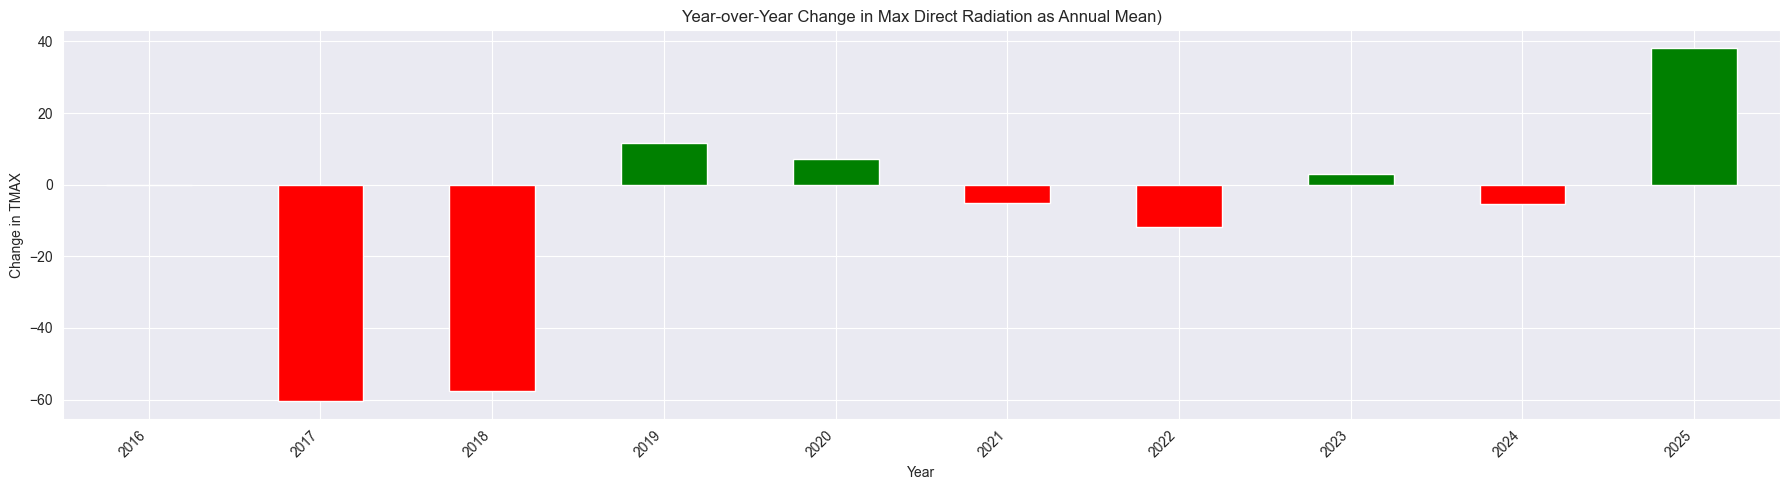

In [45]:
# Visual 1 - Month over Month percentage change of Max/Min and Avg temperature
# Compute annual mean of TMAX
max_dr_annual = (
    df_merged_monthly_summary.groupby("year", as_index=False)["max_direct_radiation"]
    .mean()
    .rename(columns={"max_direct_radiation": "max_dr_mean"})
    .dropna()
)

# Compare Year-over-year absolute change
max_dr_annual["yoy_change"] = max_dr_annual["max_dr_mean"].diff()

# Plot YoY change as a bar chart with up/down colors
colors = ["green" if v >= 0 else "red" for v in max_dr_annual["yoy_change"].fillna(0)]
ax = max_dr_annual.plot(
    x="year", y="yoy_change", kind="bar", color=colors, legend=False, figsize=(18, 5)
)
ax.set_title("Year-over-Year Change in Max Direct Radiation as Annual Mean)")
ax.set_xlabel("Year")
ax.set_ylabel("Change in TMAX")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

*Answer to research question:*
As we can see there is some variability year over year, but this last year has seen a large uptick in Maximum direct radiation. Next let's get a cleaner view and see about pinpointing by how much the temperature is trending upwards.

Estimated warming trend: 0.10 °C per decade


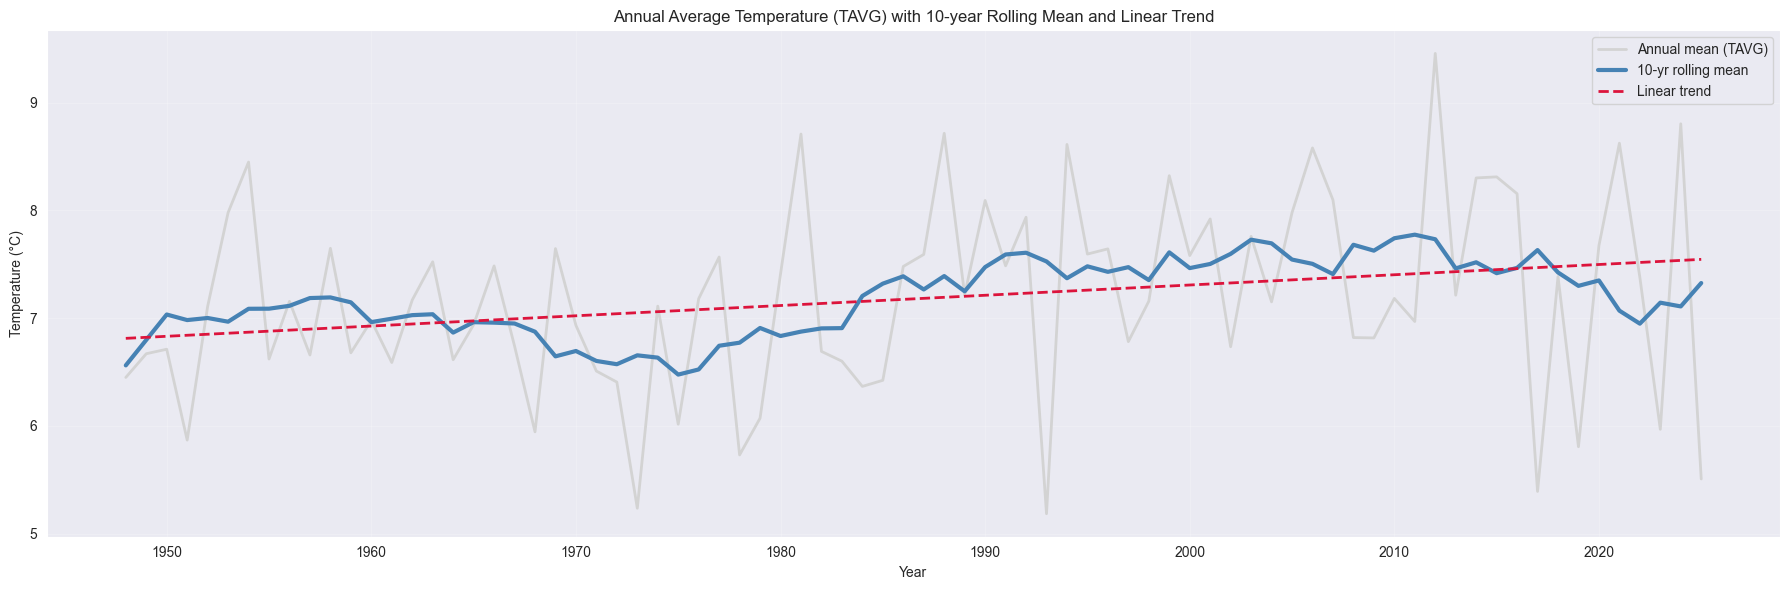

In [48]:
# Visual 2 - Annual average temperature trend (TAVG) with 10-year rolling mean and linear trend
annual_tavg = (
    df_merged_monthly_summary.groupby("year", as_index=False)["TAVG"]
    .mean()
    .rename(columns={"TAVG": "tavg_mean"})
    .sort_values("year")
)
# 10-year rolling mean (centered)
annual_tavg["roll10"] = (
    annual_tavg["tavg_mean"].rolling(10, min_periods=5, center=True).mean()
)
# Linear trend
x = annual_tavg["year"].to_numpy()
y = annual_tavg["tavg_mean"].to_numpy()
# Must have more than 2 years to build trend line
if len(annual_tavg) >= 2:
    coef = np.polyfit(x, y, 1)
    trend_fn = np.poly1d(coef)
    annual_tavg["trend"] = trend_fn(x)
    slope_decade = coef[0] * 10.0
else:
    annual_tavg["trend"] = np.nan
    slope_decade = float("nan")

plt.figure(figsize=(18, 6))
plt.plot(
    annual_tavg["year"],
    annual_tavg["tavg_mean"],
    color="lightgray",
    linewidth=2,
    label="Annual mean (TAVG)",
)
plt.plot(
    annual_tavg["year"],
    annual_tavg["roll10"],
    color="steelblue",
    linewidth=3,
    label="10-yr rolling mean",
)

if np.isfinite(slope_decade):
    plt.plot(
        annual_tavg["year"],
        annual_tavg["trend"],
        color="crimson",
        linestyle="--",
        linewidth=2,
        label="Linear trend",
    )
    plt.title(
        "Annual Average Temperature (TAVG) with 10-year Rolling Mean and Linear Trend"
    )
    print(f"Estimated warming trend: {slope_decade:.2f} °C per decade")
else:
    plt.title("Annual Average Temperature (TAVG) with 10-year Rolling Mean")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()

*Answer to research question:*
To further suggest the increase in temperature year over year we can see in the above chart that the average temperature has been trending hotter by around 0.1 degrees C.

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:*
Given more time I would like to investigate the trends as of late, and how they compare to events around the world. For example hurricanes, Cloud Seeding, and changes in emissions output or policy.
Given more time I would like to investigate further trends in the wide assortment of variables present in the Open Meteo, and NOAA data sets. By having these sets parsed aggregated and in a local database I will be able to build on this project as time goes on.